In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -v python-mecab-ko

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x7fd6c8d7a550>)

In [ ]:
data = pd.read_csv('finance_data.csv')
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
del data['sentence']

# 중복 제거
data.drop_duplicates(subset=['kor_sentence'], inplace=True)

In [ ]:
# 한국어만 남기고 싶으면
data['kor_sentence'] = [re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',' ',s) for s in data['kor_sentence']]
# 특수용어 삭제
#data['kor_sentence'] = [re.sub('[^A-Za-z0-9가-힣]', ' ', s) for s in data['kor_sentence']]

In [ ]:
data

,labels,kor_sentence
0,0,에 따르면 그 회사는 회사가 성장하고 있는 곳이지만 모든 생산을 러시아로...
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 만 평...
2,2,국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며 이전의 ...
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,년 회사의 업데이트된 전략에 따르면 는 ...
...,...,...
4841,2,런던 마켓워치 은행주의 반등이 지수의 약세를 상쇄하지 못하면서 ...
4842,0,린쿠스키아의 맥주 판매량은 만 리터로 감소했으며 카우노 알루스의 맥주...
4843,2,영업이익은 년 에서 으로 떨어졌으며 선박 판매 이...
4844,2,페이퍼 부문 순매출은 년 분기 에서 년 분기 ...


In [ ]:
#인덱스 초기화 -> 0부터 정렬
data = data.reset_index(drop=True)
data

,labels,kor_sentence,tokenized
0,0,에 따르면 그 회사는 회사가 성장하고 있는 곳이지만 모든 생산을 러시아로...,"[에, 따르, 면, 그, 회사, 는, 회사, 가, 성장, 하, 고, 있, 는, 곳,..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 만 평...,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회..."
2,2,국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며 이전의 ...,"[국제, 전자, 산업, 회사, 인, 엘코, 텍, 은, 탈린, 공장, 에서, 수십, ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,"[새로운, 생산, 공장, 으로, 인해, 회사, 는, 예상, 되, 는, 수요, 증가,..."
4,1,년 회사의 업데이트된 전략에 따르면 는 ...,"[년, 회사, 의, 업데이트, 된, 전략, 에, 따르, 면, 는, 범위, 의, 장기..."
...,...,...,...
4822,2,런던 마켓워치 은행주의 반등이 지수의 약세를 상쇄하지 못하면서 ...,"[런던, 마켓, 워치, 은행주의, 반, 등, 이, 지수, 의, 약세, 를, 상쇄, ..."
4823,0,린쿠스키아의 맥주 판매량은 만 리터로 감소했으며 카우노 알루스의 맥주...,"[린, 쿠, 스키아, 의, 맥주, 판매량, 은, 만, 리터, 로, 감소, 했으며, ..."
4824,2,영업이익은 년 에서 으로 떨어졌으며 선박 판매 이...,"[영업, 이, 익, 은, 년, 에서, 으로, 떨어졌으며, 선박, 판매, 이익, 은,..."
4825,2,페이퍼 부문 순매출은 년 분기 에서 년 분기 ...,"[페이퍼, 부문, 순, 매출, 은, 년, 분기, 에서, 년, 분기, 으로, 감소, ..."


In [ ]:
import mecab
mecab = mecab.MeCab()

In [ ]:
data['tokenized'] = data['kor_sentence'].apply(mecab.morphs)

In [ ]:
# 불용어 제거
data['remove_stopwords'] = None
stopwords = ['유로','라고','밝혔','대한','명','된다','부터','에게','등','리','관한','드','한다고','몇','코네','던','노','비','았','입니다','할','적','습니다','는다','니','저','로','것','핀란드','만','어','및','다고','고','된','될','약','게','며','지','합니다','아','또','때','겠','뿐','고','있','수','하','기','년','인','되','면','한다','에서','그','했','다','을','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
for i in range(len(data)):
  stopwords_removed_sentence = [word for word in data.iloc[i,2] if not word in stopwords] # 불용어 제거
  data['remove_stopwords'][i] = stopwords_removed_sentence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data

,labels,kor_sentence,tokenized,remove_stopwords
0,0,에 따르면 그 회사는 회사가 성장하고 있는 곳이지만 모든 생산을 러시아로...,"[에, 따르, 면, 그, 회사, 는, 회사, 가, 성장, 하, 고, 있, 는, 곳,...","[따르, 회사, 회사, 성장, 곳, 지만, 모든, 생산, 러시아, 옮길, 계획, 없]"
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 만 평...,"[테크노폴리스, 는, 컴퓨터, 기술, 과, 통신, 분야, 에서, 일, 하, 는, 회...","[테크노폴리스, 컴퓨터, 기술, 통신, 분야, 일, 회사, 유치, 위해, 평방, 미..."
2,2,국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며 이전의 ...,"[국제, 전자, 산업, 회사, 인, 엘코, 텍, 은, 탈린, 공장, 에서, 수십, ...","[국제, 전자, 산업, 회사, 엘코, 텍, 탈린, 공장, 수십, 직원, 해고, 했으..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,"[새로운, 생산, 공장, 으로, 인해, 회사, 는, 예상, 되, 는, 수요, 증가,...","[새로운, 생산, 공장, 인해, 회사, 예상, 수요, 증가, 충족, 시킬, 능력, ..."
4,1,년 회사의 업데이트된 전략에 따르면 는 ...,"[년, 회사, 의, 업데이트, 된, 전략, 에, 따르, 면, 는, 범위, 의, 장기...","[회사, 업데이트, 전략, 따르, 범위, 장기, 순, 매출, 성장, 목표, 으며, ..."
...,...,...,...,...
4822,2,런던 마켓워치 은행주의 반등이 지수의 약세를 상쇄하지 못하면서 ...,"[런던, 마켓, 워치, 은행주의, 반, 등, 이, 지수, 의, 약세, 를, 상쇄, ...","[런던, 마켓, 워치, 은행주의, 반, 지수, 약세, 상쇄, 못하, 면서, 월요일,..."
4823,0,린쿠스키아의 맥주 판매량은 만 리터로 감소했으며 카우노 알루스의 맥주...,"[린, 쿠, 스키아, 의, 맥주, 판매량, 은, 만, 리터, 로, 감소, 했으며, ...","[린, 쿠, 스키아, 맥주, 판매량, 리터, 감소, 했으며, 카우, 알, 루스, 맥..."
4824,2,영업이익은 년 에서 으로 떨어졌으며 선박 판매 이...,"[영업, 이, 익, 은, 년, 에서, 으로, 떨어졌으며, 선박, 판매, 이익, 은,...","[영업, 익, 떨어졌으며, 선박, 판매, 이익, 었]"
4825,2,페이퍼 부문 순매출은 년 분기 에서 년 분기 ...,"[페이퍼, 부문, 순, 매출, 은, 년, 분기, 에서, 년, 분기, 으로, 감소, ...","[페이퍼, 부문, 순, 매출, 분기, 분기, 감소, 반복, 항목, 제외, 영업, 이..."


In [ ]:
X_data = data['remove_stopwords']
y_data = data['labels']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [ ]:
max_features = 3500 #빈도수 상위 ##개 사용
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[261, 93, 181, 83, 64, 181, 83, 1680, 216, 923, 408, 65], [924, 925, 22, 5, 109], [23, 12, 5], [362, 1681, 174, 70, 442, 474, 71, 2035, 409, 842, 70, 1682, 175], [79, 221, 498, 333, 114]]
[[670, 607, 35, 53, 36], [24, 121, 94, 3441, 2051, 272, 588, 86, 240, 95, 2, 215, 6], [505, 71, 235, 569, 69, 2806, 860, 73, 753, 2339, 914], [282, 10, 64, 129, 23, 108, 108, 315], [1, 3, 486, 112, 25, 455, 29, 956, 207, 167, 2029, 1, 1, 20, 956, 207, 1, 3, 961, 227, 17]]


In [ ]:
# vocab_size = 5
# words_frequency = [w for w,c in word_to_index.items() if c >= vocab_size + 1] # 인덱스가 5 초과인 단어 제거
# for w in words_frequency:
#     del word_to_index[w] # 해당 단어에 대한 인덱스 정보를 삭제
# print(word_to_index)

In [ ]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size) # 단어 개수

6748


In [ ]:
word_to_index

{'월': 1,
 '회사': 2,
 '일': 3,
 '었': 4,
 '증가': 5,
 '말': 6,
 '서비스': 7,
 '업체': 8,
 '영업': 9,
 '분기': 10,
 '그룹': 11,
 '이익': 12,
 '계약': 13,
 '사업': 14,
 '시장': 15,
 '억': 16,
 '예정': 17,
 '순': 18,
 '였': 19,
 '까지': 20,
 '제공': 21,
 '매출': 22,
 '기간': 23,
 '총': 24,
 '주식': 25,
 '포함': 26,
 '제조': 27,
 '위한': 28,
 '발표': 29,
 '개발': 30,
 '감소': 31,
 '제품': 32,
 '인수': 33,
 '새로운': 34,
 '생산': 35,
 '투자': 36,
 '공장': 37,
 '키': 38,
 '고객': 39,
 '개': 40,
 '오이': 41,
 '매출액': 42,
 '솔루션': 43,
 '운영': 44,
 '같': 45,
 '달러': 46,
 '기록': 47,
 '중': 48,
 '여': 49,
 '공급': 50,
 '직원': 51,
 '비해': 52,
 '기술': 53,
 '주': 54,
 '으며': 55,
 '사용': 56,
 '판매': 57,
 '건설': 58,
 '기업': 59,
 '은행': 60,
 '노키아': 61,
 '이번': 62,
 '보다': 63,
 '순이익': 64,
 '예상': 65,
 '시스템': 66,
 '오늘': 67,
 '않': 68,
 '러시아': 69,
 '지분': 70,
 '라': 71,
 '계획': 72,
 '산업': 73,
 '전': 74,
 '우리': 75,
 '위해': 76,
 '프로젝트': 77,
 '시작': 78,
 '거래': 79,
 '체결': 80,
 '통해': 81,
 '두': 82,
 '데': 83,
 '성': 84,
 '동안': 85,
 '따라': 86,
 '수익': 87,
 '다른': 88,
 '지역': 89,
 '현재': 90,
 '해': 91,
 '헬싱': 92,
 '사': 93

본문의 최대 길이 : 37
본문의 평균 길이 : 12.006216006216006


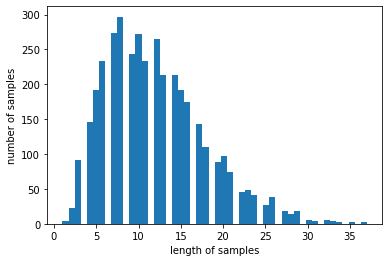

In [ ]:
print('본문의 최대 길이 :',max(len(sent) for sent in X_train))
print('본문의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

3861
3861


In [ ]:
max_len = 25

In [ ]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [ ]:
X_train_encoded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  261,   93,  181,   83,   64,  181,   83, 1680,  216,
        923,  408,   65], dtype=int32)

In [ ]:
X_train_encoded.shape

(3861, 25)

In [ ]:
X_test_encoded.shape

(966, 25)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
embedding_dim = 25
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, 
                    epochs=2, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/2
96/97 [============================>.] - ETA: 0s - loss: 0.9373 - acc: 0.5807
Epoch 1: val_acc improved from -inf to 0.66365, saving model to best_model.h5
97/97 [==============================] - 8s 10ms/step - loss: 0.9359 - acc: 0.5819 - val_loss: 0.7931 - val_acc: 0.6636
Epoch 2/2
96/97 [============================>.] - ETA: 0s - loss: 0.6594 - acc: 0.7126
Epoch 2: val_acc improved from 0.66365 to 0.72962, saving model to best_model.h5
97/97 [==============================] - 1s 5ms/step - loss: 0.6584 - acc: 0.7131 - val_loss: 0.6380 - val_acc: 0.7296


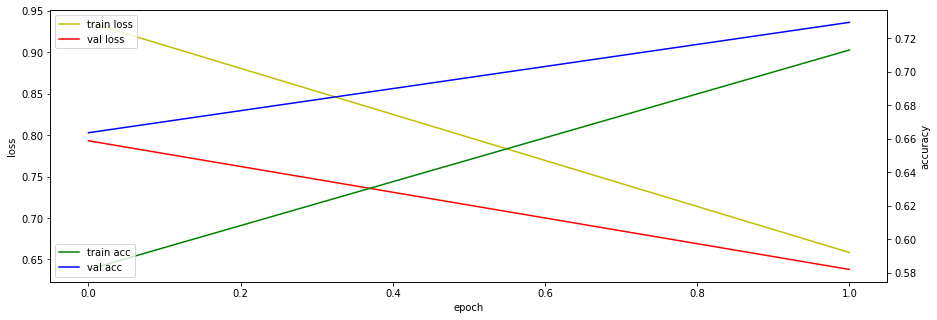

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(15,5))

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'g', label='train acc')
acc_ax.plot(history.history['val_acc'], 'b', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
score = model.evaluate(X_test_encoded, y_test)
print('loss', score[0])
print('accuracy', score[1])

31/31 [==============================] - 0s 3ms/step - loss: 0.6343 - acc: 0.7350
loss 0.6343380808830261
accuracy 0.7349896430969238


In [ ]:
loaded_model = load_model('best_model.h5')

In [ ]:
model.save('lstm_model_2.h5')

## 예측해보기